## Import the package and data

In [12]:
import numpy as np
import pandas as pd
import math
import torch
import matplotlib.pyplot  as plt
import matplotlib
import copy
from lifelines import CoxPHFitter

from random import shuffle
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset,ConcatDataset
from torch import nn
from torchvision import datasets,transforms
from scipy.stats import chi2
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
from DML_COX import *
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def ToTensor(data):
    return torch.tensor(np.array(data)).to(torch.float32)

def numPercent(data):
    for col in data.columns:
        num = data[col].isna().sum() # nan个数
        print(col,num / len(data)) # 占比

def impute_NA(data,print_state=False):
    data=data.astype(np.float32)
    subset_na = np.isnan(data)
    if print_state:
        print(np.median(data[~subset_na]))
    data[subset_na] = np.median(data[~subset_na])
    return data


In [4]:
# read colon.csv
colon = pd.read_csv('colon.csv')
colon_rec = colon.iloc[range(1,len(colon),2)]
colon_death = colon.iloc[range(0,len(colon),2)]

data = colon_death
# print(data.head())
T = ToTensor(data.time).unsqueeze(1)
D = ToTensor(data.status).unsqueeze(1)
X = ToTensor(pd.get_dummies(data.rx))[:,0:2]
print(data.rx)
print(X)

0       Lev+5FU
2       Lev+5FU
4           Obs
6       Lev+5FU
8           Obs
         ...   
1848    Lev+5FU
1850        Lev
1852        Lev
1854    Lev+5FU
1856        Lev
Name: rx, Length: 929, dtype: object
tensor([[0., 1.],
        [0., 1.],
        [0., 0.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]])


In [5]:
sex = ToTensor(data.sex).unsqueeze(1)
age = ToTensor(data.age).unsqueeze(1)
obstruct = ToTensor(data.obstruct).unsqueeze(1)
perfor = ToTensor(data.perfor).unsqueeze(1)
adhere = ToTensor(data.adhere).unsqueeze(1)
nodes = (ToTensor(impute_NA(data.nodes,print_state=True))).unsqueeze(1)
differ = (ToTensor(pd.get_dummies(impute_NA(data.differ,print_state=True))))[:,1:3]
extent = (ToTensor(pd.get_dummies(data.extent)))[:,1:4]
surg = (ToTensor(data.surg)).unsqueeze(1)
node4 = (ToTensor(data.node4)).unsqueeze(1)

Z=feature_normalize(torch.cat((sex,age,obstruct,perfor,adhere,nodes,differ,extent,surg,node4),axis=1))
mydat = DeepSurvData(T,D,X,Z,device)
print(mydat.Z.shape)

2.0
2.0
torch.Size([929, 13])


## Estimating $\theta(Z)$, $\Lambda(t)$ by Partial linear Cox methods

In [8]:
# np.random.seed(2024)
sample=np.random.permutation(np.arange(len(mydat.T)))
sample1 = sample[0:800]
sample2 = sample[800:len(sample)]
mydat_train = mydat[sample1] 
mydat_test = mydat[sample2]
print(mydat_train.Z.shape)

torch.Size([800, 13])


In [7]:
model_theta = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],100),
    nn.ReLU(),
    nn.Linear(100,1),
)

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],50),
    nn.ReLU(),
    nn.Linear(50,mydat.X.shape[1]),
    nn.Sigmoid(),
)


Epoch_XZ=181
lr_XZ=5e-4
Epoch_theta=181
lr_theta=5e-4


beta_est,theta_est = fit_CoxPH(mydat_train,device=device,model=model_theta,
                               Epoch=Epoch_theta, lr=lr_theta,
                               Test_set=mydat_test,print_state=True)
print(beta_est)

# T_interval = torch.quantile(mydat.T,torch.arange(0,0.9,0.2).to(device))
# print('train E[X|Z,T>t]')
# model_XZ = fit_XZ_complete(mydat_train,T_interval=T_interval,device=device,loss_fn=nn.BCELoss(),
#                            model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
#                            Test_set=mydat_test,print_state=True)


epoch: 0 Train_loss:3.17800, epoch: 0 Test_loss:2.16688
epoch: 10 Train_loss:3.15559, epoch: 10 Test_loss:2.14714
epoch: 20 Train_loss:3.13690, epoch: 20 Test_loss:2.13167
epoch: 30 Train_loss:3.12170, epoch: 30 Test_loss:2.12076
epoch: 40 Train_loss:3.10966, epoch: 40 Test_loss:2.11367
epoch: 50 Train_loss:3.10018, epoch: 50 Test_loss:2.10963
epoch: 60 Train_loss:3.09254, epoch: 60 Test_loss:2.10783
epoch: 70 Train_loss:3.08609, epoch: 70 Test_loss:2.10714
epoch: 80 Train_loss:3.08033, epoch: 80 Test_loss:2.10702
epoch: 90 Train_loss:3.07490, epoch: 90 Test_loss:2.10729
tensor([-0.2292,  0.1405], device='cuda:0')


## Double Robust Estimation

In [9]:
model_theta = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,1),
)

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,mydat.X.shape[1]),
    nn.Sigmoid(),
)

# model_theta = nn.Sequential(
#     nn.Linear(mydat.Z.shape[1],100),
#     nn.Sigmoid(),
#     nn.Linear(100,1),
# )

# # define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
# model_XZ = nn.Sequential(
#     nn.Linear(mydat.Z.shape[1],50),
#     nn.Sigmoid(),
#     nn.Linear(50,mydat.X.shape[1]),
#     nn.Sigmoid(),
# )

Epoch_XZ=181
lr_XZ=3e-4
Epoch_theta=181
lr_theta=5e-4
accuracy=0.1

In [20]:
np.random.seed(2024);torch.manual_seed(2024)
sample=np.random.permutation(np.arange(len(mydat.T)))
sample1 = sample[0:800]
sample2 = sample[800:len(sample)]
mydat_train = mydat[sample1] 
mydat_test = mydat[sample2]


# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(mydat_train, device=device,accuracy=accuracy, Test_set= mydat_test,
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

beta_naive=(beta_est1+beta_est2)/2
net = CustomNet(h_dims=[1, 50,50,50, 2], g_dims=[13,50,50,50, 2])
var_est_naive = fit_variance(mydat_train, net, device=device, lr=4e-5,Epoch=400,print_state=False)

# (beta_DB, var_est, 
#  beta_est1, deepSurv1,  model_XZ1, 
#  beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(mydat, device=device,accuracy=accuracy, Test_set= False,
#                                               model_XZ=model_XZ, model_theta=model_theta,
#                                               Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
#                                               lr_XZ=lr_XZ, lr_theta=lr_theta,
#                                               print_state=True)



# # calculate the direct parameter estimator without using double robust techniques

# # calculate the p_value
# beta=torch.zeros(2).to(device)
# chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est) @ torch.unsqueeze(beta_DB-beta,1))
# p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
# p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est)).cpu(),1)
# print()
# print('直接估计偏差：',beta_naive-beta,'偏差模长：',torch.norm(beta_naive-beta))
# print('双重鲁棒估计偏差：',beta_DB-beta,'偏差模长：',torch.norm(beta_DB-beta))
# print('双重鲁棒估计标准差：',torch.sqrt(torch.diag(var_est)))
# print('双重鲁棒估计检验 H_0: β=β_0, p值：%.5f'%p_value_joint)
# for i in range(len(beta_DB)):
#     print('双重鲁棒估计检验 H_0: β[%d]=β_0[%d], p值：%.5f'%(i,i,p_value_single[i]))

train theta(Z)
epoch: 0 Train_loss:3.13245, epoch: 0 Test_loss:2.17253
epoch: 10 Train_loss:3.10170, epoch: 10 Test_loss:2.14686
epoch: 20 Train_loss:3.07209, epoch: 20 Test_loss:2.12256
epoch: 30 Train_loss:3.04555, epoch: 30 Test_loss:2.10449
epoch: 40 Train_loss:3.03127, epoch: 40 Test_loss:2.10508
epoch: 50 Train_loss:3.01829, epoch: 50 Test_loss:2.10998
train E[X|Z,T>t]
epoch: 0 Train_loss:2.41777, epoch: 0 Test_loss:2.44508
epoch: 10 Train_loss:2.36372, epoch: 10 Test_loss:2.39134
epoch: 20 Train_loss:2.31695, epoch: 20 Test_loss:2.34519
epoch: 30 Train_loss:2.27507, epoch: 30 Test_loss:2.30330
epoch: 40 Train_loss:2.23520, epoch: 40 Test_loss:2.26250
epoch: 50 Train_loss:2.19555, epoch: 50 Test_loss:2.22158
epoch: 60 Train_loss:2.15566, epoch: 60 Test_loss:2.18064
epoch: 70 Train_loss:2.11627, epoch: 70 Test_loss:2.14096
epoch: 80 Train_loss:2.07960, epoch: 80 Test_loss:2.10461
epoch: 90 Train_loss:2.04752, epoch: 90 Test_loss:2.07363
epoch: 100 Train_loss:2.02087, epoch: 100 Te

In [21]:
# var_est_naive=var_est_naive.to(device)
print()
beta=torch.zeros(2).to(device)
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


PL Cox bias： tensor([0.2568, 0.1574], device='cuda:0') bias norm: tensor(0.3012, device='cuda:0')
PL Cox standard error： tensor([0.1196, 0.1261], device='cuda:0')
PL Cox test H_0: β=β_0, p value：0.09414
PL Cox test H_0: β[0]=β_0[0], p value：0.03181
PL Cox test H_0: β[1]=β_0[1], p value：0.21165

DBPL bias： tensor([-0.1171, -0.3390], device='cuda:0') DBPL bias： tensor(0.3586, device='cuda:0')
DBPL standard error： tensor([0.1124, 0.1249], device='cuda:0')
DBPL test H_0: β=β_0, p value：0.02440
DBPL test H_0: β[0]=β_0[0], p value：0.29738
DBPL test H_0: β[1]=β_0[1], p value：0.00666


## Cross validation

In [22]:
def toPandas(data):
    return  pd.DataFrame(torch.cat([data.T.cpu(), data.D.cpu(),data.X.cpu(),data.Z.cpu()],1))  

np.random.seed(2024); torch.manual_seed(1)

model_theta = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,1),
)

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,mydat.X.shape[1]),
    nn.Sigmoid(),
)

# model_theta = nn.Sequential(
#     nn.Linear(mydat.Z.shape[1],100),
#     nn.Sigmoid(),
#     nn.Linear(100,1),
# )

# # define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
# model_XZ = nn.Sequential(
#     nn.Linear(mydat.Z.shape[1],50),
#     nn.Sigmoid(),
#     nn.Linear(50,mydat.X.shape[1]),
#     nn.Sigmoid(),
# )

Epoch_XZ=181
lr_XZ=3e-4
Epoch_theta=181
lr_theta=1e-3
accuracy=0.1

In [23]:
np.random.seed(2024); torch.manual_seed(1)
BETA_DB = list()
BETA_NAIVE = list()
BETA_COX = list()

SE_DB = list()
SE_NAIVE = list()
SE_COX = list()

np.random.seed(2024)
sample = np.random.permutation(np.arange(len(mydat.T)))
# Split the vector into 5 random parts
split_vector = np.array_split(sample, 5)
# Print the resulting split vector
for i, sample_val in enumerate(split_vector):
    mask = np.isin(sample, sample_val, invert=True)
    mydat_train = mydat[sample[mask]] 
    mydat_test = mydat[sample_val]
    
    # train the double robust model
    (beta_DB, var_est_DB, 
     beta_est1, deepSurv1,  model_XZ1, 
     beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(mydat_train, device=device,accuracy=accuracy, Test_set= mydat_test,
                                                  model_XZ=model_XZ, model_theta=model_theta,
                                                  Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                                  lr_XZ=lr_XZ, lr_theta=lr_theta,
                                                  print_state=False)

    beta=torch.zeros(2)
    beta_naive=(beta_est1+beta_est2)/2
    net = CustomNet(h_dims=[1, 50,50,50, len(beta)], g_dims=[13,50,50,50, len(beta)])
    var_est_naive = fit_variance(mydat_train, net, device=device, lr=4e-5,Epoch=400,print_state=False)
    
    cph = CoxPHFitter()
    cph.fit(toPandas(mydat_train), 0, 1)
    # cph.print_summary()
    beta_Cox = np.array(cph.params_[0:2])
    se_Cox = np.sqrt(np.diag(cph.variance_matrix_)[0:2])

    BETA_DB.append(beta_DB.cpu())
    BETA_NAIVE.append(beta_naive.cpu())
    BETA_COX.append(beta_Cox)
    SE_COX.append(se_Cox)
    SE_NAIVE.append(np.sqrt(np.diag(var_est_naive.cpu())))
    SE_DB.append(np.sqrt(np.diag(var_est_DB.cpu())))

    print(i,end=' ')
    pass



0 1 2 3 4 

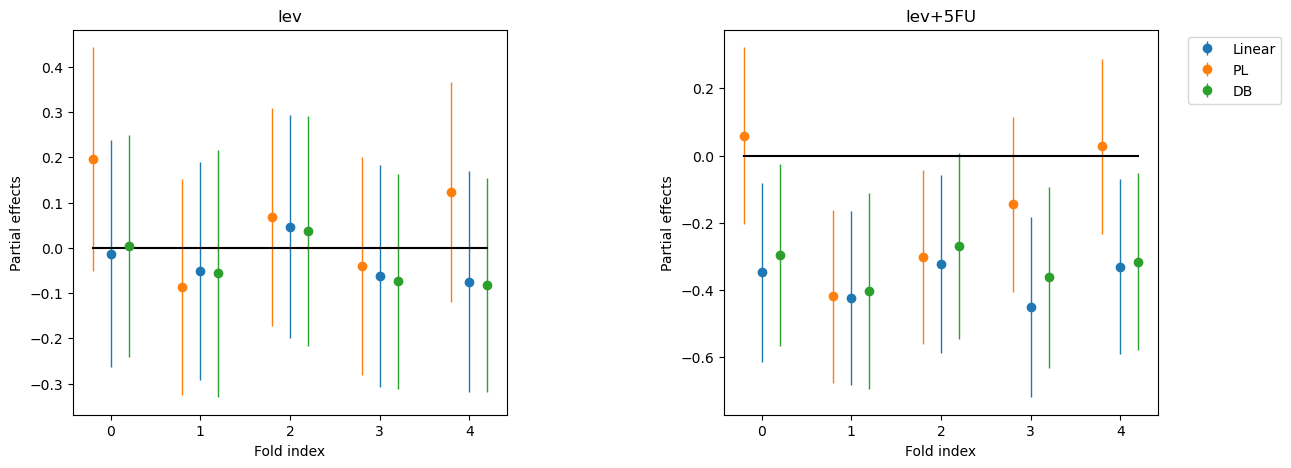

In [25]:
plt.figure(figsize=[14,5])
plt.subplot(1,2,1)
plt.errorbar(range(5), np.array(BETA_COX)[:,0],1.96*np.array(SE_COX)[:,0],fmt='o', linewidth=1)
plt.errorbar(np.arange(5)-0.2, np.array(BETA_NAIVE)[:,0],1.96*np.array(SE_NAIVE)[:,0],fmt='o', linewidth=1)
plt.errorbar(np.arange(5)+0.2, np.array(BETA_DB)[:,0],1.96*np.array(SE_DB)[:,0],fmt='o', linewidth=1)
plt.plot([-0.2,4.2],[0,0],color='black')
plt.xlabel('Fold index')
plt.ylabel('Partial effects')
plt.title('lev')

plt.subplot(1,2,2)
plt.errorbar(range(5), np.array(BETA_COX)[:,1],1.96*np.array(SE_COX)[:,1],fmt='o',label='Linear', linewidth=1)
plt.errorbar(np.arange(5)-0.2, np.array(BETA_NAIVE)[:,1],1.96*np.array(SE_NAIVE)[:,1],fmt='o',label='PL', linewidth=1)
plt.errorbar(np.arange(5)+0.2, np.array(BETA_DB)[:,1],1.96*np.array(SE_DB)[:,1],fmt='o',label='DB', linewidth=1)
plt.plot([-0.2,4.2],[0,0],color='black')
plt.xlabel('Fold index')
plt.ylabel('Partial effects')
# plt.ylim(-0.6,1)
plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1))

plt.title('lev+5FU')

plt.subplots_adjust(wspace=0.5)
plt.savefig('colon_death.pdf')
plt.show()